In [294]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

year = 2018

Preprocessing

In [295]:
df = pd.read_csv('datasets/shooting.csv')

df['CrimeDate'] = pd.to_datetime(df['CrimeDate'], format='%Y-%m-%d')
df = df[(df['CrimeDate'].dt.year >= year) & (df['CrimeDate'].dt.year <= year)]

print(len(df))
df.tail()

677


,Unnamed: 0,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside_Outside,Weapon,Post,District,Neighborhood,Latitude,Longitude,GeoLocation,Premise,Total_Incidents
3109,564787,2018-10-31,15:00:00,9S,1000 HOLLINS ST,SHOOTING,Inside,FIREARM,931.0,SOUTHERN,HOLLINS MARKET,39.287549,-76.635082,"(39.28754930499052,-76.635082456943465)",COMMON BUSINESS,1
3112,566257,2018-12-31,22:08:00,9S,2800 SPRINGHILL AV,SHOOTING,Outside,FIREARM,612.0,NORTHWEST,PARK CIRCLE,39.331266,-76.662881,"(39.331266198075639,-76.66288100157351)",STREET,1
3113,566258,2018-12-31,22:08:00,9S,700 WHITMORE AV,SHOOTING,Outside,FIREARM,721.0,WESTERN,EVERGREEN LAWN,39.295557,-76.658166,"(39.2955565493506,-76.658166447821344)",PUBLIC AREA,1
3114,566263,2018-12-31,22:10:00,9S,1200 E PRESTON ST,SHOOTING,Outside,FIREARM,314.0,EASTERN,OLIVER,39.305131,-76.601749,"(39.305130593546622,-76.601748899565564)",PUBLIC AREA,1
3115,566264,2018-12-31,22:10:00,9S,1200 E PRESTON ST,SHOOTING,Outside,FIREARM,314.0,EASTERN,OLIVER,39.305131,-76.601749,"(39.305130593546622,-76.601748899565564)",PUBLIC AREA,1


DBSCAN Clustering

In [296]:
location = df[['Latitude','Longitude']]

# Hapus data yang tidak memiliki koordinat
location = location.dropna()

# Hanya gunakan data yang berada di radius 39, -75 (Kota Baltimore) 
location = location.loc[(location['Latitude']>39) & (location['Longitude'] < -75)]  

In [297]:
print('=== Null ===')
print(location.isnull().sum())
print('=== Shape ===')
print(location.shape)

lenght = len(location)

=== Null ===
Latitude     0
Longitude    0
dtype: int64
=== Shape ===
(675, 2)


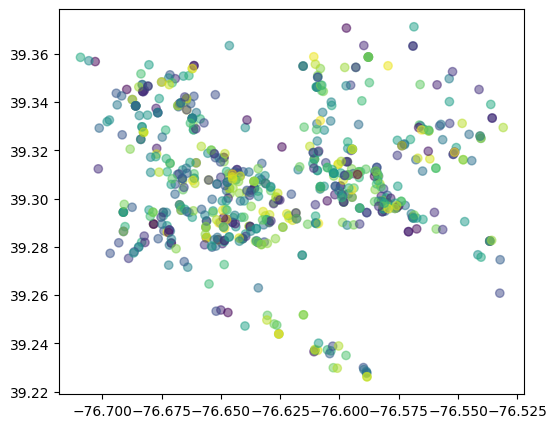

In [298]:
x = location['Longitude']
y = location['Latitude']

colors = np.random.rand(len(x))

plt.figure(figsize=(6,5))
plt.scatter(x, y,c=colors, alpha=0.5)
plt.show()

In [299]:
import folium
import re

m = folium.Map(location=[df.Latitude.median(), df.Longitude.median()], zoom_start=12, 
               tiles='OpenStreet Map')

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row.Latitude, row.Longitude],
        radius=5,
        popup=re.sub(r'[^a-zA-Z ]+', '', row.Location),
        color='#1787FE',
        fill=True,
        fill_colour='#1787FE'
    ).add_to(m)
    
m

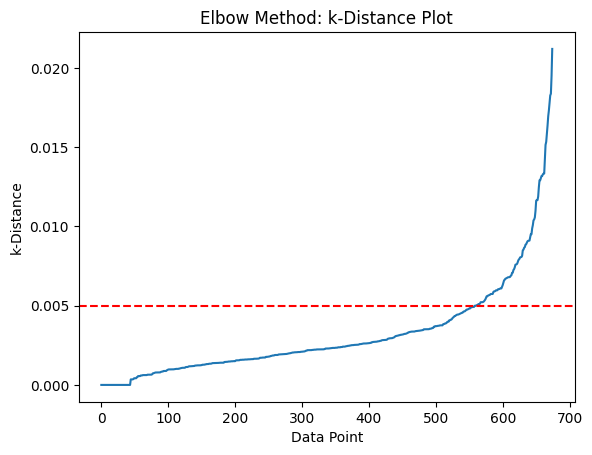

Nilai epsilon yang disarankan: 0.005


In [300]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Data
XD = location
XD = XD[~np.isnan(XD)]
X = XD.dropna()

# K-Distance = 2x(Jumlah Dimensi)
nn = NearestNeighbors(n_neighbors=4)
nn.fit(X)
distances, _ = nn.kneighbors(X)

# Sorting distances
distances = np.sort(distances, axis=0)
distances = distances[:, -1]

# Plot k-distance
plt.plot(distances)

# Mencari perubahan yang signifikan dalam k-distance
differences = np.diff(distances)
max_diff = np.argmax(differences) + 1

# Menentukan epsilon
epsilon = 0.005
plt.axhline(y=epsilon, color='r', linestyle='--')

plt.xlabel('Data Point')
plt.ylabel('k-Distance')
plt.title('Elbow Method: k-Distance Plot')
plt.show()

print("Nilai epsilon yang disarankan:", epsilon)


In [301]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

X = df[['Latitude', 'Longitude']]
X = X.dropna()

db = DBSCAN(eps=0.004, min_samples=5).fit(X)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Membuat y_pred secara otomatis dengan lokasi koordinat di sekitar X
random_range = 0.001  # Rentang acak di sekitar setiap titik X
y_pred = np.zeros(len(X))

for i, (lat, lon) in enumerate(X.values):
    lat_random = np.random.uniform(lat - random_range, lat + random_range)
    lon_random = np.random.uniform(lon - random_range, lon + random_range)
    y_pred[i] = np.random.choice(labels)

completeness = metrics.completeness_score(y_pred, labels)
homogeneity = metrics.homogeneity_score(y_pred, labels)
v_measure = metrics.v_measure_score(y_pred, labels)
adjusted_rand_index = metrics.adjusted_rand_score(y_pred, labels)
adjusted_mutual_info = metrics.adjusted_mutual_info_score(y_pred, labels)
precision = metrics.precision_score(y_pred, labels, average='micro')

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print('======')
print("Completeness: %0.3f" % completeness)
print("Homogeneity: %0.3f" % homogeneity)
print("V-measure: %0.3f" % v_measure)
print("Adjusted Rand Index: %0.3f" % adjusted_rand_index)
print("Adjusted Mutual Information: %0.3f" % adjusted_mutual_info)
print("Precision Score: %0.3f" % precision)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 36
Estimated number of noise points: 149
Completeness: 0.202
Homogeneity: 0.201
V-measure: 0.202
Adjusted Rand Index: 0.003
Adjusted Mutual Information: -0.006
Precision Score: 0.092
Silhouette Coefficient: 0.116
